# Metrics during GRACE era

In this notebook, we compare our TWS reconstruction to the GRACE, our target.

In [1]:
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR

In [2]:
# Register dask progress bar
ProgressBar(minimum=5).register()

In [3]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "figures/si"

Open model predictions:

In [4]:
# Load and combine our predictions
pred_dir = ROOT_DIR / "models/predictions/ensemble-mixed"

ours_list = []

for inp_name in ["era", "era-rdcd", "wghm-era"]:
    twsa_ours = xr.open_zarr(pred_dir / f"ensemble-mixed_{inp_name}_best-mae.zarr").twsa
    ours_list.append(twsa_ours.rename(f"twsa_ours_{inp_name}"))
ours = xr.merge(ours_list)


In [5]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
recs = xr.open_zarr(recs_store)

In [ ]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, ours, recs])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean


/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xskillscore/core/np_deterministic.py:626: RuntimeWarning: Mean of empty slice
  mean_squared_error = meanfunc(squared_error, axis=axis)


Specify variables of interest and their descriptive names:

In [7]:
vars_verbose = {
    "twsa_ours_era": "DeepRec",
    "twsa_ours_wghm-era": "DeepRec, w/ WGHM",
    "twsa_gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "palazzoli_jpl_full": "Palazzoli's JPL Rec",
    "twsa_csr": "CSR (GRACE)",
}
eval_names = list(vars_verbose.keys())

target_name = "twsa_csr"
eval_names.remove(target_name)


## Score / correlation world maps
### Pixel-wise RMSE

In [8]:
ds_grid = ds_all[[target_name, *eval_names]]
# Only evaluate GRACE time
ds_grid = ds_grid.sel(time=slice("2002", "2023")).compute()
# Remove missing time steps - remove missing time steps in GRACE for all vars
ds_grid = ds_grid.where(ds_grid.dr.time_notnull(), drop=True)

In [9]:
times = ds_grid.get_index("time")
print(f"Timespan: {times[0].date()} to {times[-1].date()}")

Timespan: 2002-04-01 to 2019-07-01


In [10]:
preds_rmse = metrics.rmse(
    ds_grid[target_name], ds_grid[eval_names], dim="time", skipna=True
)
with np.errstate(divide="ignore", invalid="ignore"):
    da_rmse = preds_rmse.to_dataarray("model", name="rmse").compute()

In [11]:
plot_kwargs = dict(
    vmin=0,
    vmax=140,
    cmap=cmc.batlow_r,
    col_wrap=2,
    coastlines=True,
    gridlines=True,
    rasterized=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.02),
    figsize=(6, 8.25),
)
basinlines_kwargs = dict(
    edgecolor="black", linewidth=0.3, facecolor="None", rasterized=True, zorder=3.0
)

/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


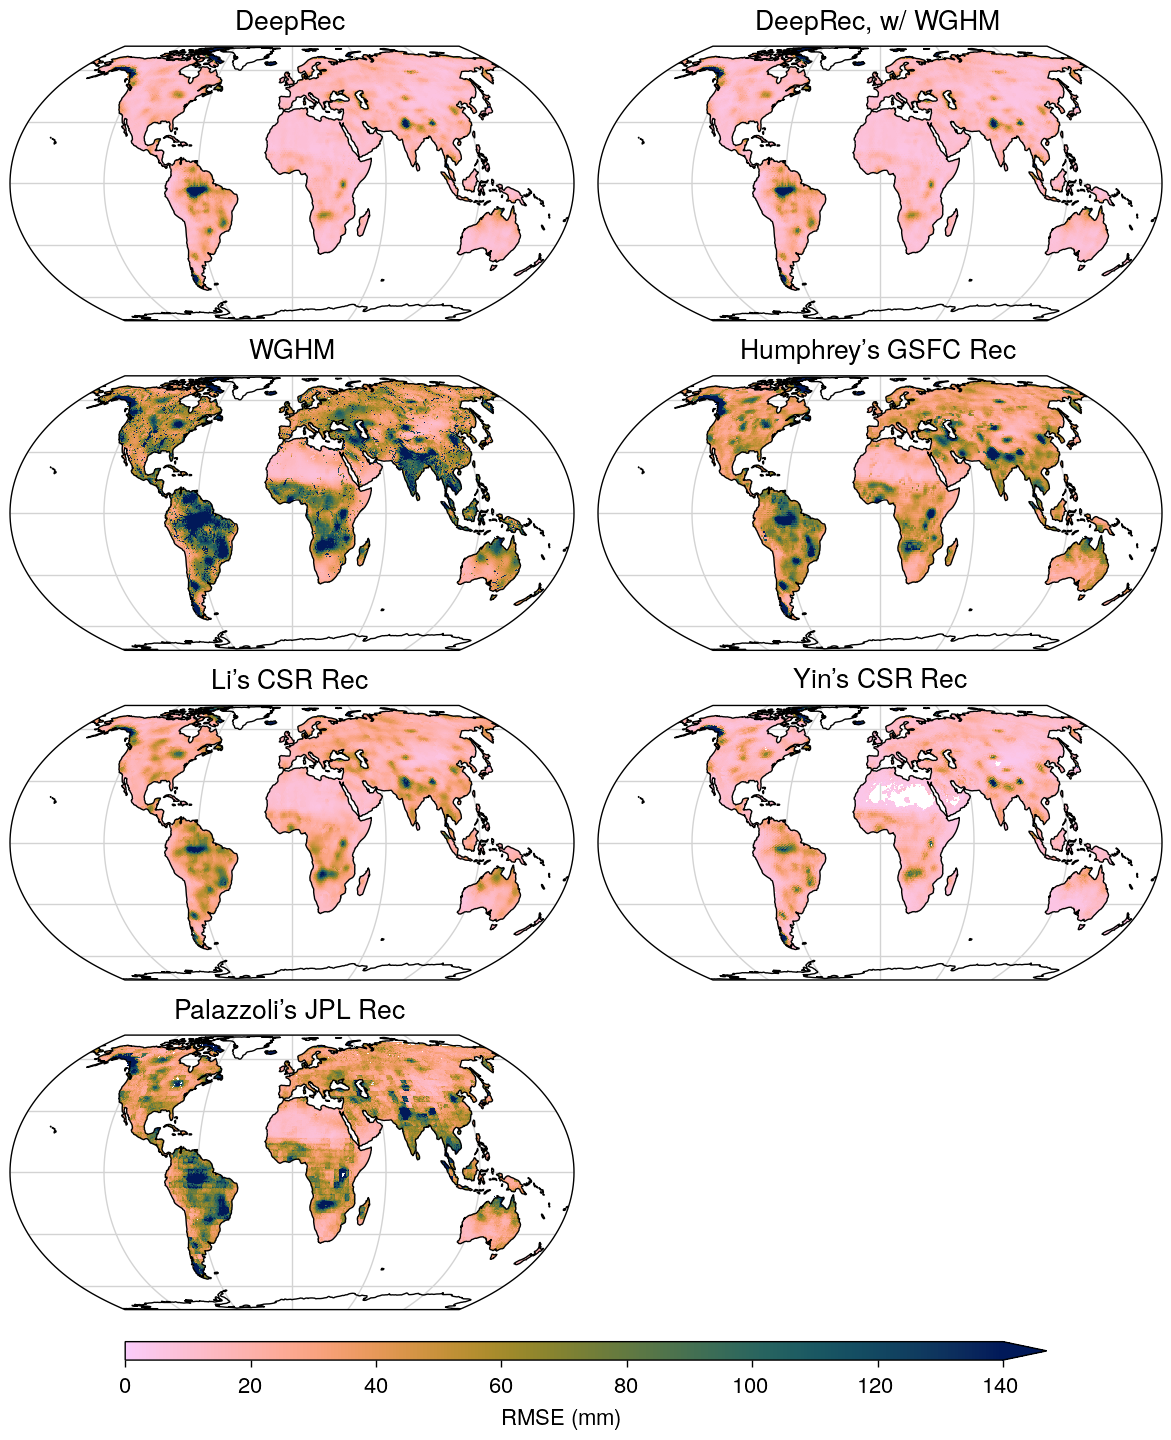

In [ ]:
plot_kwargs["cbar_kwargs"]["label"] = "RMSE (mm)"
p = da_rmse.dr.projplot(col="model", **plot_kwargs)

for ax, model in zip(p.axs.flat, da_rmse.model.values):
    ax.set_title(vars_verbose[model])

p.fig.savefig(FIGURE_DIR / "grace_rmse_gridwise.pdf", backend="pgf")

### Basin-wise RMSE

Calculate the basin average time series:

In [14]:
# Calculate basin averages
ds_basin: xr.Dataset = (
    # Select variables and time frame of interest
    ds_grid.chunk(time=10, lat=-1, lon=-1)
    .dr.select_basins(top=72)
    .dr.weight_lat()
    .mean(["lat", "lon"])
    .compute()
)


[########################################] | 100% Completed | 44.00 s


In [15]:
preds_basin_rmse = metrics.rmse(ds_basin[target_name], ds_basin[eval_names], dim="time")
da_basin_rmse = preds_basin_rmse.to_dataarray("model", name="rmse").compute()

/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


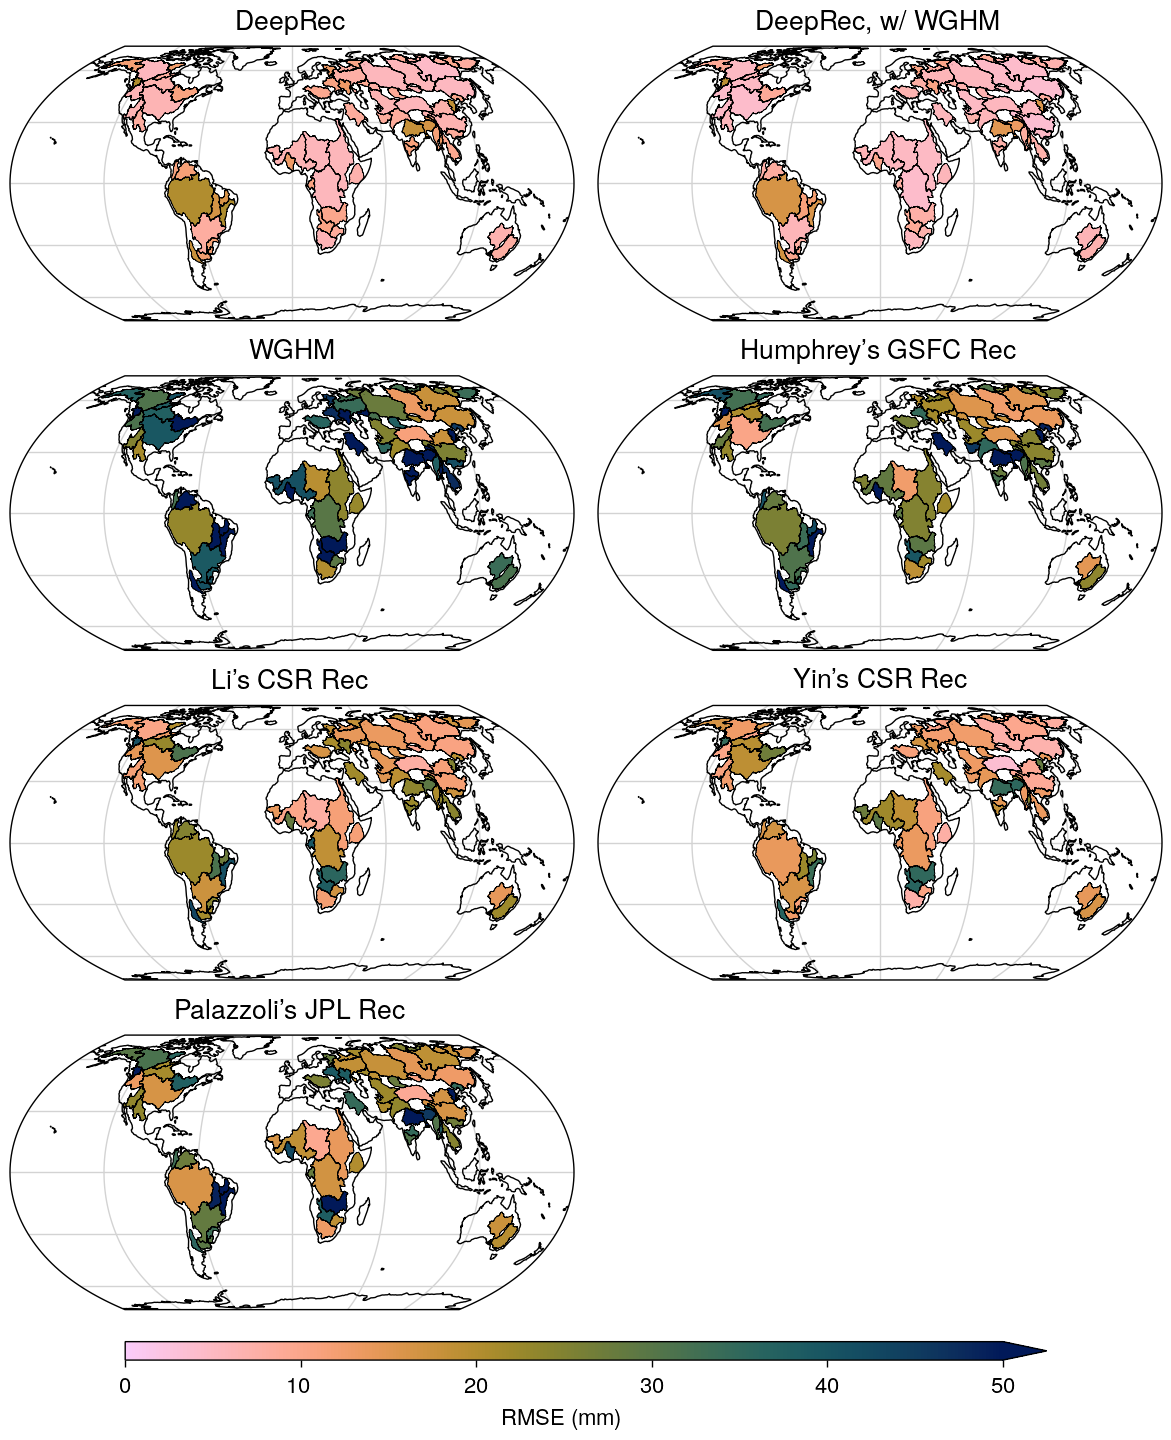

In [16]:
plot_kwargs["vmax"] = 50

p = da_basin_rmse.dr.projplot_basins(da_rmse, col="model", **plot_kwargs)

# Plot basin shapes
basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_rmse.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(FIGURE_DIR / "grace_rmse_basinwise.pdf", backend="pgf")

### Nash–Sutcliffe model efficiency coefficient (NSE)

Nash-Sutcliffe Efficiency (NSE) as per [Nash and Sutcliffe, 1970](https://doi.org/10.1016/0022-1694(70)90255-6).
$$
E_{\text{NSE}} = 1 - \frac{\sum_{i=1}^{N}[e_{i}-s_{i}]^2}
{\sum_{i=1}^{N}[e_{i}-\mu(e)]^2}
$$

where *N* is the length of the *simulations* and *evaluation*
periods, *e* is the *evaluation* series, *s* is (one of) the
*simulations* series, and *μ* is the arithmetic mean.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


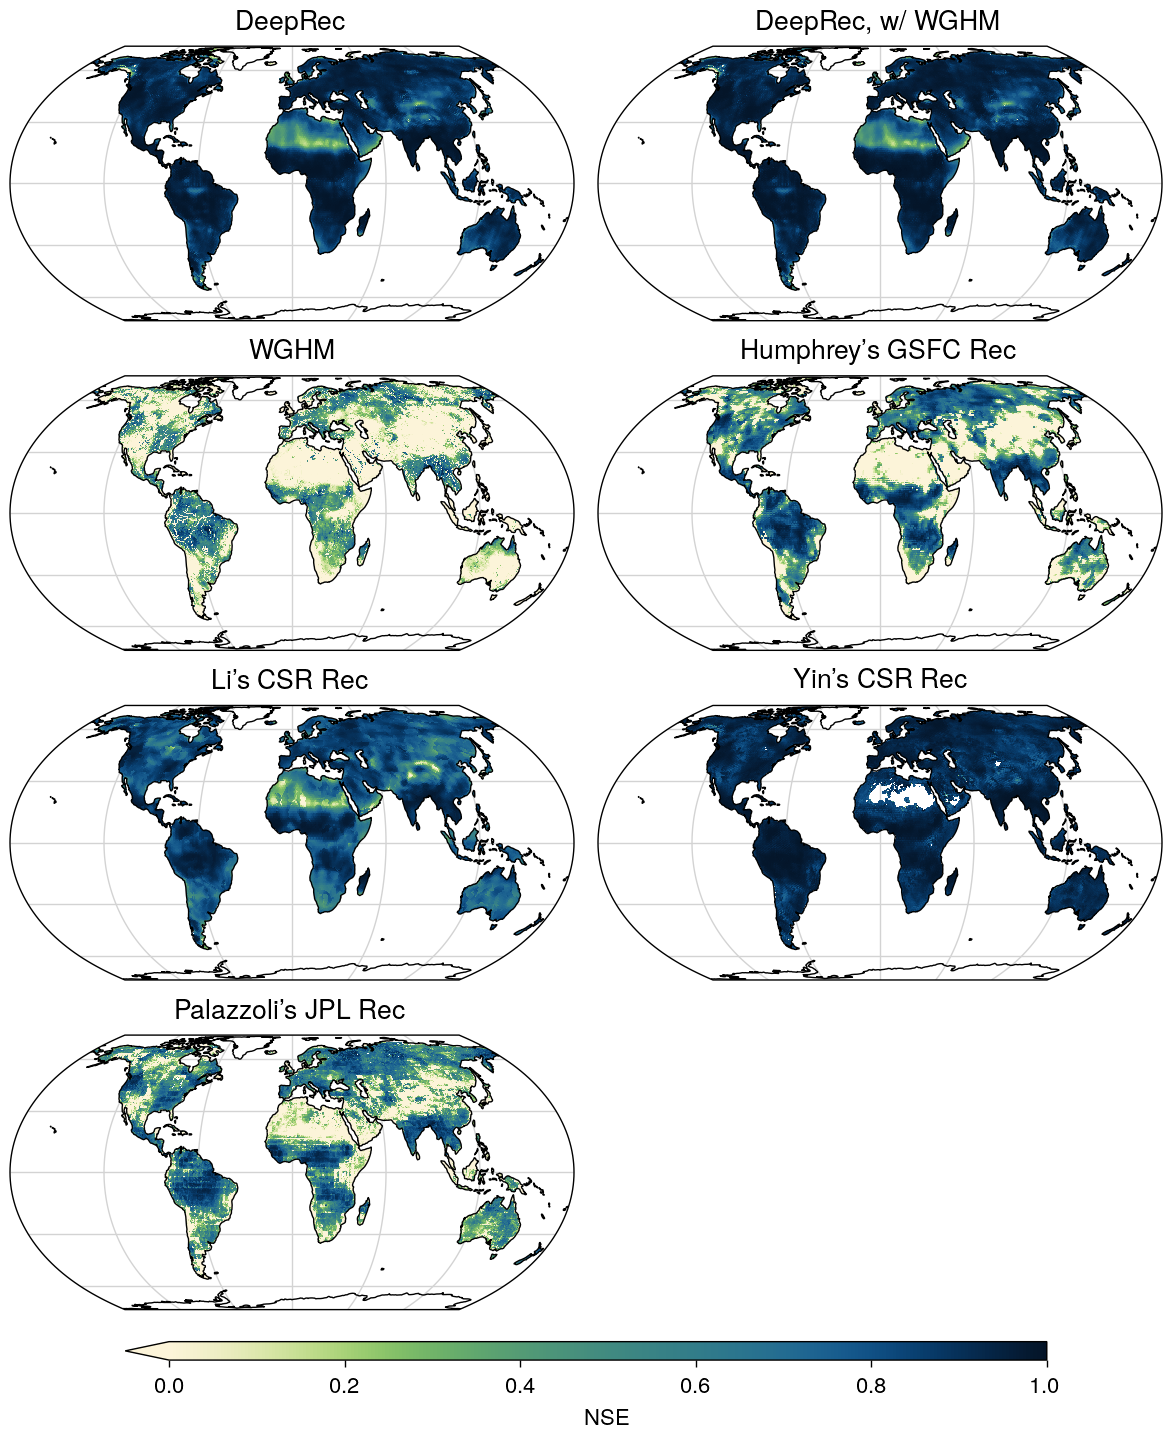

In [17]:
preds_nse = metrics.nse(
    ds_grid[target_name], ds_grid[eval_names], dim="time", skipna=True
)
with np.errstate(divide="ignore", invalid="ignore"):
    da_nse = preds_nse.to_dataarray("model", name="nse").compute()

plot_kwargs["vmin"] = 0
plot_kwargs["vmax"] = 1
plot_kwargs["cmap"] = cmc.navia_r
plot_kwargs["cbar_kwargs"]["label"] = "NSE"

p = da_nse.dr.projplot(col="model", **plot_kwargs)

for ax, model in zip(p.axs.flat, da_nse.model.values):
    ax.set_title(vars_verbose[model])
p.fig.savefig(FIGURE_DIR / "grace_nse_gridwise.pdf", backend="pgf")

/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


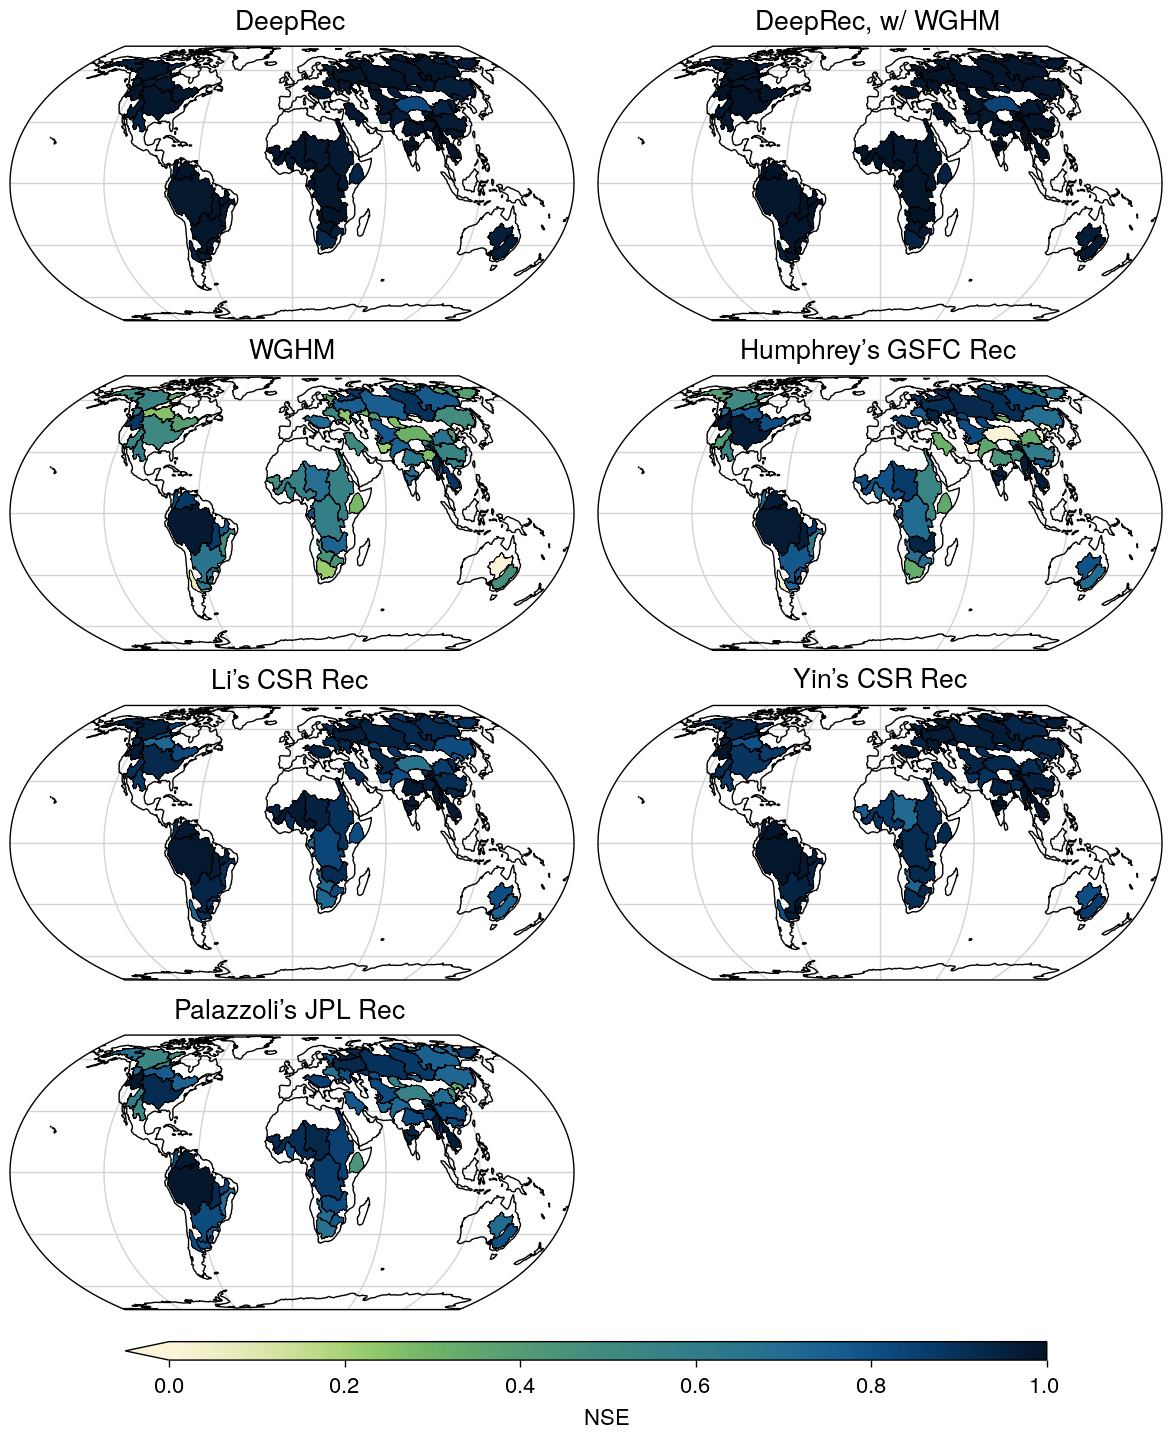

In [18]:
preds_basin_nse = metrics.nse(ds_basin[target_name], ds_basin[eval_names], dim="time")
da_basin_nse = preds_basin_nse.to_dataarray("model", name="nse")

p = da_basin_nse.dr.projplot_basins(da_nse, col="model", **plot_kwargs)

for ax, model in zip(p.axs.flat, da_nse.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)
p.fig.savefig(FIGURE_DIR / "grace_nse_basinwise.pdf", backend="pgf")

### Modified Kling–Gupta efficiency (KGE')

Modified Kling-Gupta Efficiency (KGE') as per [Kling et al., 2012](https://doi.org/10.1016/j.jhydrol.2012.01.011).

$$
    \text{KGE}^\prime = 1 -
    \sqrt{(r-1)^2 + (\beta-1)^2 + (\gamma-1)^2} \\
    r = \frac{\text{cov}(y, \hat y)}{\sigma \hat \sigma} \\
    \beta = \frac{\hat \mu}{\mu} \\
    \gamma = \frac{\hat \sigma / \hat \mu}{\sigma / \mu}
$$

In [19]:
plot_kwargs["vmin"] = -1
# No diverging colormap, as KGE=0 has no inherent meaning as with NSE
plot_kwargs["cmap"] = cmc.bamako_r

/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xskillscor

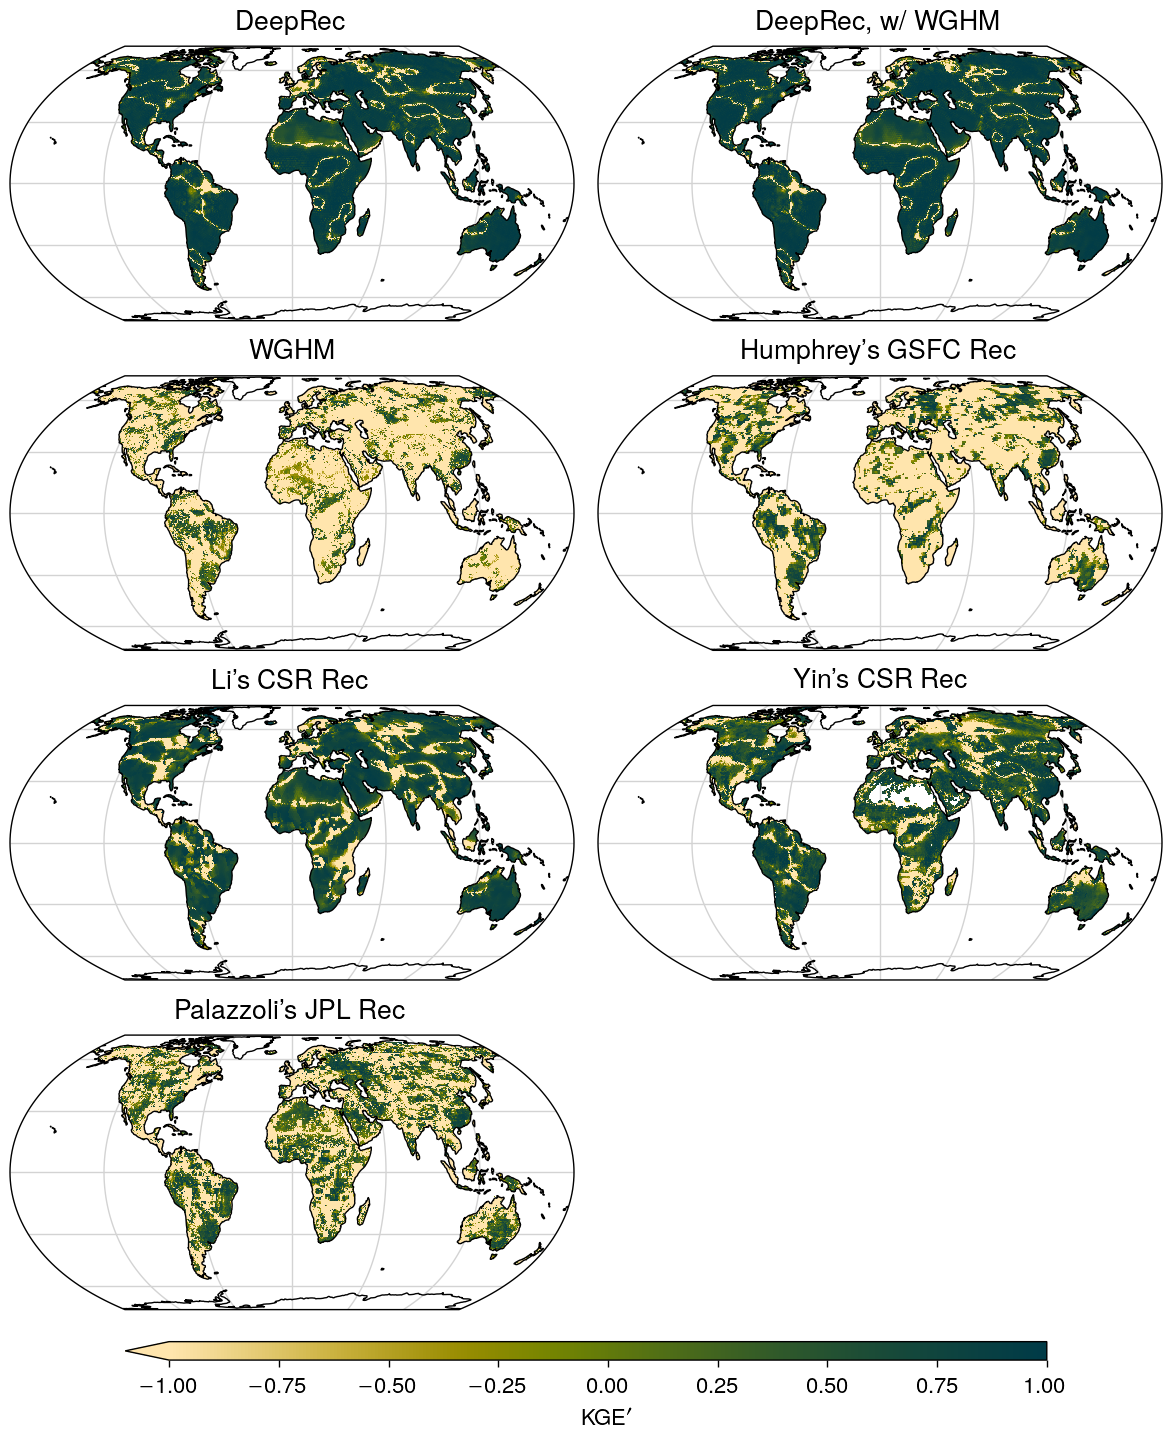

In [20]:
preds_kge = metrics.kgeprime(
    ds_grid[target_name], ds_grid[eval_names], dim="time", skipna=True
)
with np.errstate(divide="ignore", invalid="ignore"):
    da_kge = preds_kge.to_dataarray("model", name="kge").compute()

plot_kwargs["cbar_kwargs"]["label"] = r"KGE$^\prime$"


p = da_kge.dr.projplot(col="model", **plot_kwargs)

for ax, model in zip(p.axs.flat, da_kge.model.values):
    ax.set_title(vars_verbose[model])

p.fig.savefig(FIGURE_DIR / "grace_kge_gridwise.pdf", backend="pgf")

/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


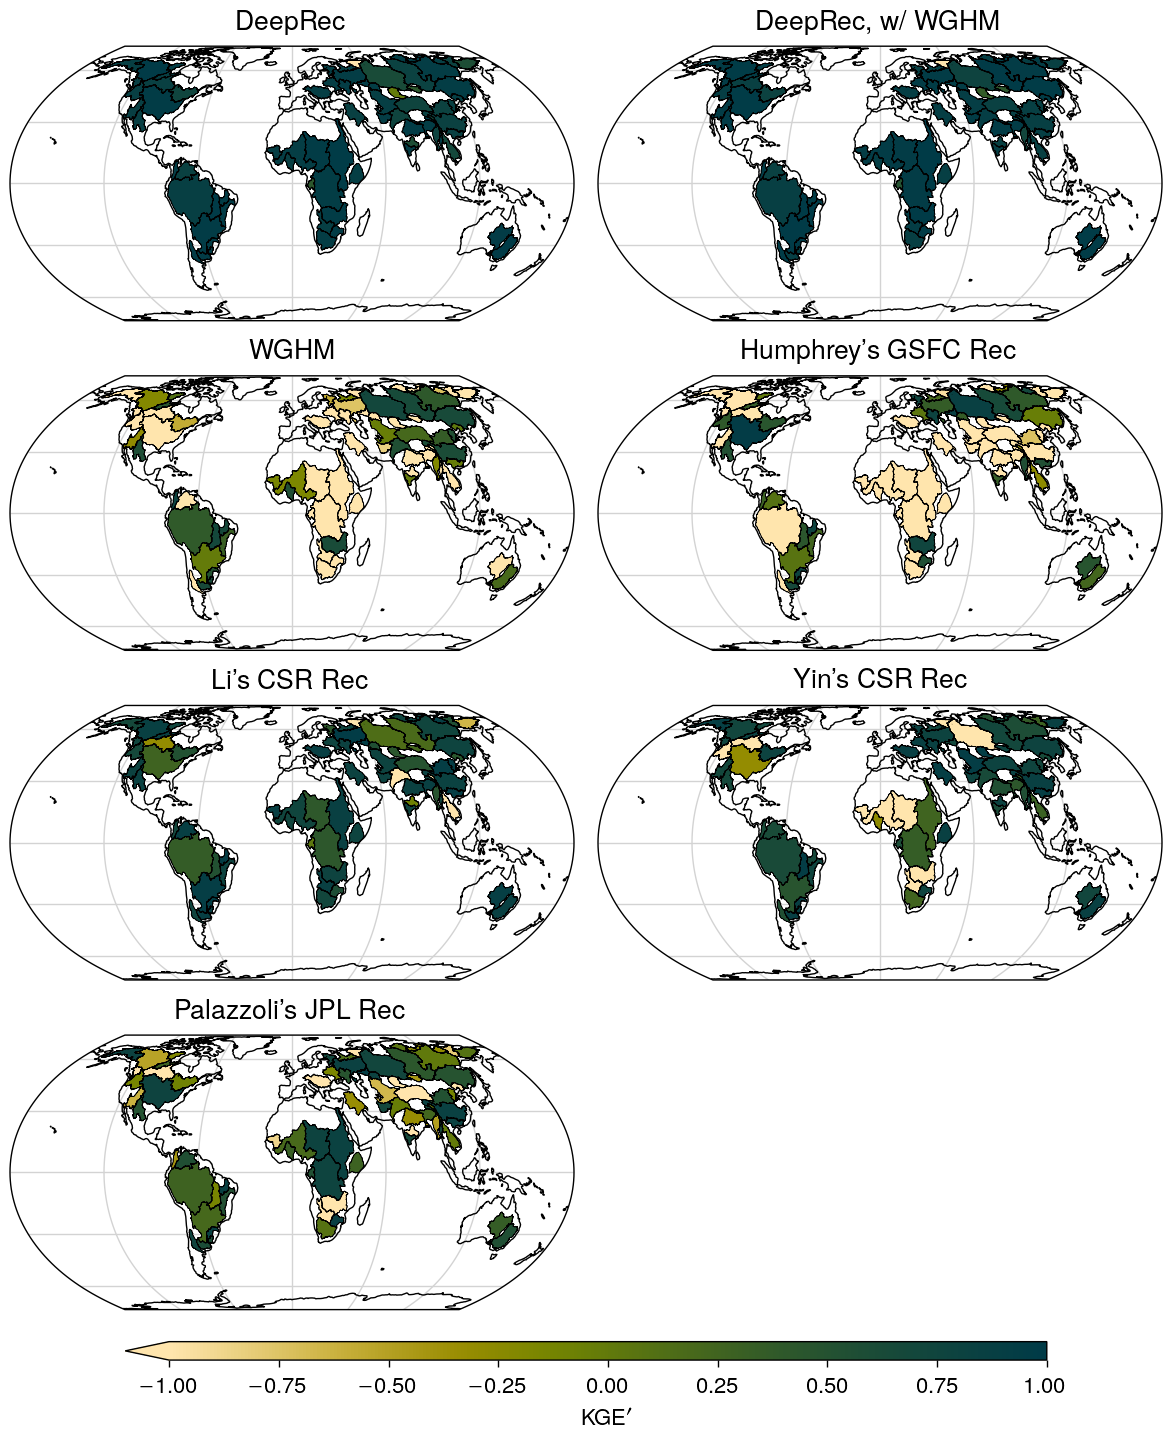

In [21]:
preds_basin_kge = metrics.kgeprime(
    ds_basin[target_name], ds_basin[eval_names], dim="time"
)
da_basin_kge = preds_basin_kge.to_dataarray("model", name="kge")

p = da_basin_kge.dr.projplot_basins(da_kge, col="model", **plot_kwargs)

for ax, model in zip(p.axs.flat, da_kge.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)
p.fig.savefig(FIGURE_DIR / "grace_kge_basinwise.pdf", backend="pgf")

## Averaged RMSE

Calculate the averaged grid-wise RMSE:

In [22]:
rmse_grid_avg = (
    da_rmse.dr.weight_lat().mean(["lat", "lon"]).rename("Grid scale RMSE").compute()
)

Calculate the averaged basin-wise RMSE. We weigh each basin by the basin area:

In [23]:
basin_areas = basin_shapes.set_index(
    basin_shapes.riverbasin.rename("region")
).shape_area
area_weights = xr.DataArray.from_series(basin_areas)

In [24]:
rmse_basin_avg = (
    da_basin_rmse.weighted(area_weights)
    .mean("region")
    .rename("Basin scale RMSE")
    .compute()
)

In [25]:
table = (
    xr.merge([rmse_basin_avg, rmse_grid_avg])
    .to_pandas()
    .rename(vars_verbose)
    .sort_values(by="Basin scale RMSE")
)
table

Basin scale RMSE  Grid scale RMSE
model                                                 
DeepRec, w/ WGHM             6.860387        21.659433
DeepRec                      8.575293        24.533213
Yin's CSR Rec               14.579635        20.168546
Li's CSR Rec                16.629930        29.307013
Palazzoli's JPL Rec         22.653461        53.837459
Humphrey's GSFC Rec         25.874663        53.052625
WGHM                        33.154849        84.591722

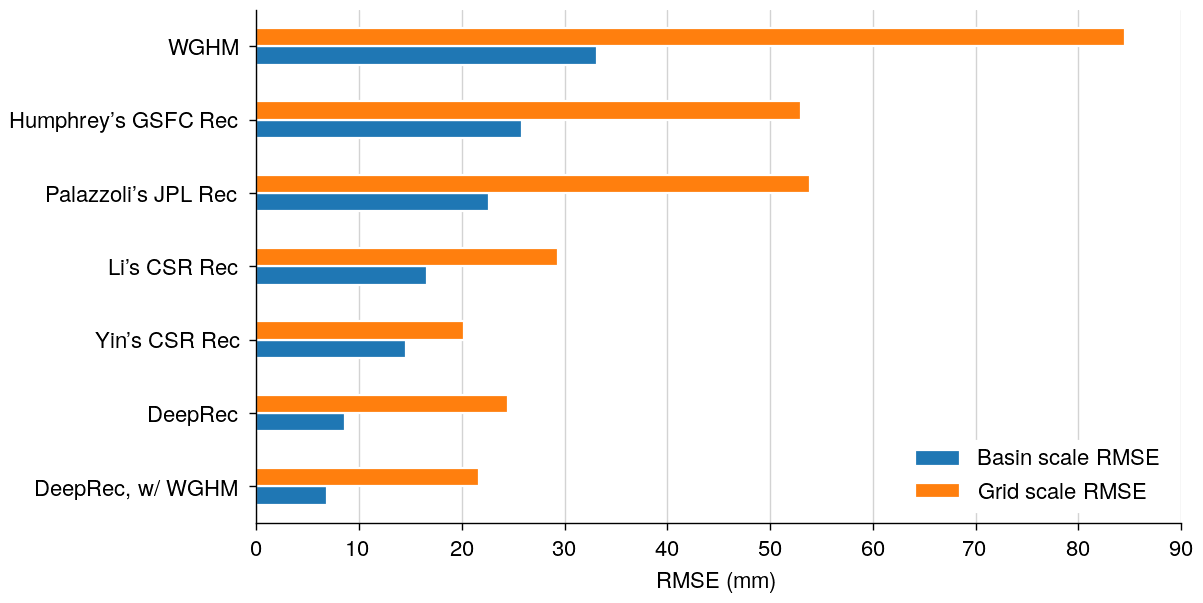

In [26]:
fig, ax = plt.subplots(figsize=(6, 3))
table.plot.barh(ax=ax)
ax.yaxis.grid(False)
ax.set(xlabel="RMSE (mm)", ylabel=None, xlim=(0, 90))
ax.legend(loc="lower right", frameon=True)
ax.xaxis.grid(True)
fig.savefig(FIGURE_DIR / "grace_rmse_globalavg.pdf", backend="pgf")

# Time series

Use the full available GRACE period (some of the other reconstructions are not available for after 2020, which is why those time steps where dropped before)

In [27]:
ds_gracetime = ds_all[[*eval_names, target_name]].where(tgts.time)
rmse_time = (
    metrics.rmse(
        ds_gracetime[target_name],
        ds_gracetime[eval_names],
        dim=[],
        skipna=True,
    )
    .dr.weight_lat()
    .mean(["lat", "lon"])
    .compute()
)
rmse_time

<xarray.Dataset> Size: 14kB
Dimensions:                (time: 222)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 2002-04-01 ... 2024-09-01
Data variables:
    twsa_ours_era          (time) float64 2kB 20.56 18.22 17.31 ... nan nan nan
    twsa_ours_wghm-era     (time) float64 2kB 17.74 15.92 15.32 ... nan nan nan
    twsa_gap               (time) float64 2kB 69.55 63.27 62.34 ... nan nan nan
    humphrey_gsfc_detrend  (time) float64 2kB 42.28 42.18 41.64 ... nan nan nan
    li_csr_full            (time) float64 2kB 28.27 23.54 23.08 ... nan nan nan
    yin_csr_full           (time) float64 2kB 15.76 15.44 14.24 ... nan nan nan
    palazzoli_jpl_full     (time) float64 2kB 40.16 38.01 36.75 ... nan nan nan

In [28]:
import pandas as pd

/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


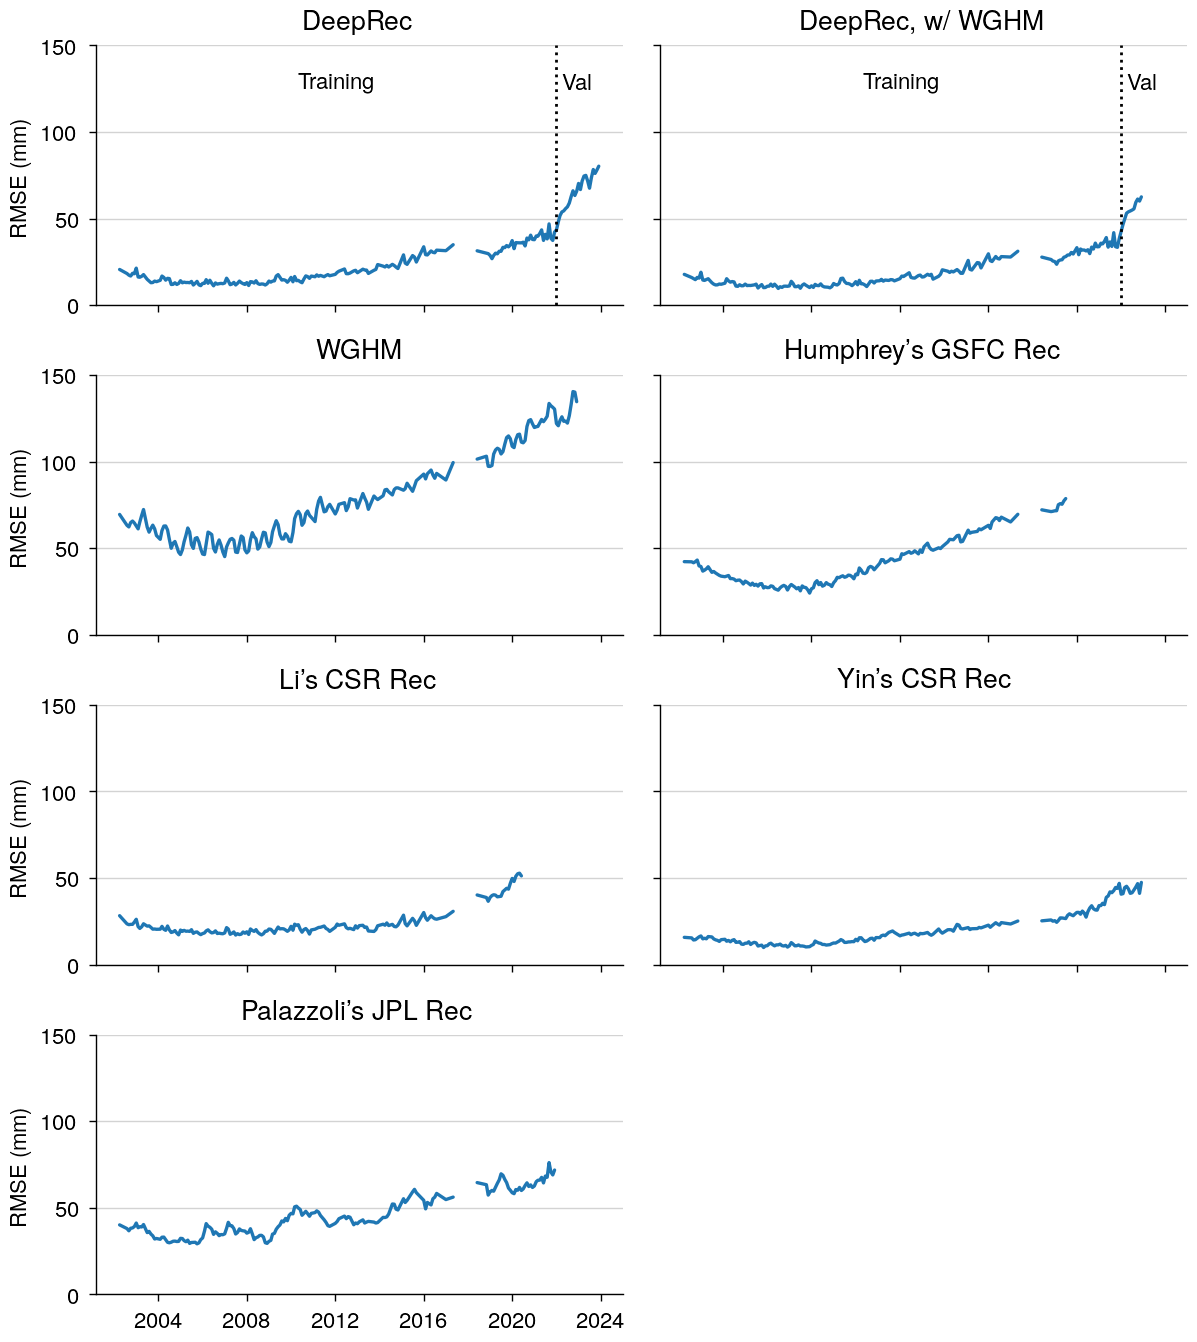

In [29]:
da_rmse_time = rmse_time.dr.insert_grace_gap_nans().to_dataarray("model")
p = da_rmse_time.plot(col="model", col_wrap=2, ylim=(0, 150), figsize=(6, 7))
for ax, model in zip(p.axs.flat, da_rmse_time.model.values):
    ax.set(title=vars_verbose[model], xlabel=None, ylabel="RMSE (mm)")
    ax.label_outer()
    ax.yaxis.grid(True)

# Color training and validation period
# Train start
t1 = pd.Timestamp("2002-03-01")
# Val start
t2 = pd.Timestamp("2022-01-01")
# Val end
t3 = pd.Timestamp("2023-12-01")
OUR_AXS = p.axs.flat[:2]

for i, ax in enumerate(OUR_AXS):
    # Train | Val
    ax.axvline(x=t2, linestyle="dotted", linewidth=1, color="black")
    ax.text(
        t1 + (t2 - t1) / 2,
        125,
        "Training",
        ha="center",
        va="baseline",
    )
    ax.text(
        t2 + (t3 - t2) / 2,
        125,
        "Val",
        ha="center",
        va="baseline",
    )

p.fig.savefig(FIGURE_DIR / "grace_rmse_globaltime.pdf", backend="pgf")